In this notebook I will load the NASC values measured by Sailbuoy in Tromsoflaket exported from EV and combine them with the interpolated position data.
The purpose is to create a small map of zooplankton abundance in a small region with bin depths for the upper 30 m.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import array as arr
import seaborn as sns
import datetime

import inv_methods_fun as inv

In [2]:
sns.set_theme(style="darkgrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

## Load NASC values

In [3]:
fname = glob.glob('E:\GLIDER2018\Echosounder\SymbiosesFlaket\EVExport\*.csv')
nfiles = len(fname)


integration_df = pd.read_csv(fname[0], usecols=[4,7,12,13])
for ind in np.arange(0,nfiles-1):
    df = pd.read_csv(fname[ind+1], usecols=[4,7,12,13])
    integration_df = integration_df.append(df, ignore_index=True)

In [4]:
times = np.array([])
ntimes = len(integration_df)
for ind in range(0,ntimes):
    times = np.append(times, datetime.datetime.strptime('%s %s' %(integration_df['Date_M'][ind],integration_df['Time_M'][ind]), '%Y%m%d %H:%M:%S.%f'))
    
integration_df['datetime'] = times

## Load SB location
The Sailbuoy location is not saved with the acoustic data. It is saved seperately with temperature and other sensors.

In [5]:
SB_env_df = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SB_env_tromsøflaket2018.xlsx',header=0, engine="openpyxl")
SB_env_times = SB_env_df.set_index(['datetime']).resample('1min').interpolate()

Find nearest time to cell time

In [6]:
index = []
for ind in range(len(times)):
    ind_index = SB_env_times.index.get_loc(times[ind], method="nearest")
    index = np.append(index, ind_index)


### Add latitude and longitude 

In [7]:
#Reset index
SB_env_times = SB_env_times.reset_index()

NASC_df = pd.DataFrame()
long = SB_env_times['longitude (deg)'][index]
lat = SB_env_times['latitude (deg)'][index]
NASC_df['Longitude'] = np.array(long)
NASC_df['Latitude'] = np.array(lat)

#### Fill in NASC dataframe

In [8]:
NASC_df['NASC'] = integration_df['NASC']
NASC_df['depthbin_min'] = integration_df['Layer_depth_min']

# NASC dataframe
This dataframe has everything they need. 

Important to note:
    - Bin sizes are 2m deep, the bin depth min is the upper value of that bin.
    - Values above 2m, maybe also 4m are not available because of the blind zone from the Sailbuoy (echosounder is mounted 1m below the surface + the near field ~1m + bubbles).

# Plot NASC value along transect

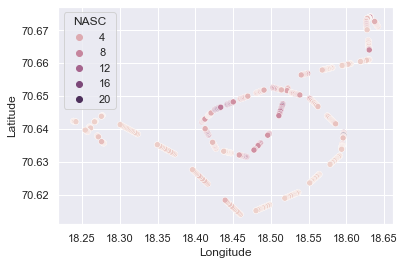

In [9]:
#Select depth bin * Must be even
select_depth=16

#scatter plot
sns.scatterplot(data=NASC_df[NASC_df['depthbin_min']==select_depth], x='Longitude',y='Latitude',hue='NASC')

## NASC to biomass
Now I need to convert NASC into a meaningful biological metric of zooplankton abundance. SInce 90% of the catch is from Calanus, I can assume the signal is from copepods for this situaiton. How do I backcalculate copepods density for each NASC values

##### One average copepod in Tromsofaket
Using the avreage properties of a single copepod in Tromsoflaket

In [10]:
# Sigmabs from ZooScatR model runs + viscous elactic model for mean of fish larvae model by ve=True)
fname_sim = '../ZooScatStuff/my_simplified_data.feather'
specs, freqs_sim, sig_bs_mean = inv.read_scatteringmodelsimulations(fname_sim, nsim=1000, ve=True)

In [11]:
sig_bs_copepod = sig_bs_mean[np.where(freqs_sim>333)[0][0],specs=='Limacina']
sig_bs_amphipod = sig_bs_mean[np.where(freqs_sim>333)[0][0],specs=='Amphipod']
sig_bs = (0.9*sig_bs_copepod)+(0.1*sig_bs_amphipod)
sig_bs

array([4.89606324e-07])

##### Density

NASC/sig_bs - individuals/nmi2


We will use sa/sigbs = NASC/(sig_bs*4*pi*1852^2) which gives individual/m2



In [12]:
rho_a = NASC_df['NASC']/(sig_bs*4*np.pi*((1852)^2)*2)

In [13]:
NASC_df['rho_a (ind/m3)'] = rho_a

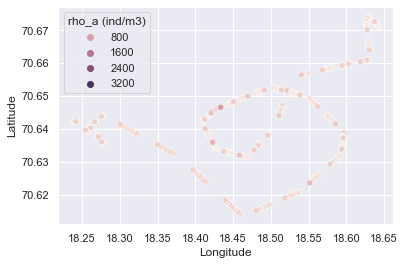

In [14]:
#Select depth bin * Must be even
select_depth = 10

#scatter plot
sns.scatterplot(data=NASC_df[NASC_df['depthbin_min']==select_depth], x='Longitude',y='Latitude',hue='rho_a (ind/m3)')

In [15]:
np.median(NASC_df['NASC'])

0.886371

## $ind/m^3$ --> $g/m^3$

In [22]:
# Using values from thesis_Hernandez (Master thesisNéstor Sanata Hernàndez 2019)
# copepod mean weight = 0.0002g
# limacina mean weight = 0.0013g
mean_weight = (0.0002*0.9) + (0.0013*0.1)

In [17]:
biomass = mean_weight*rho_a
NASC_df['biomass (g/m3)'] = biomass

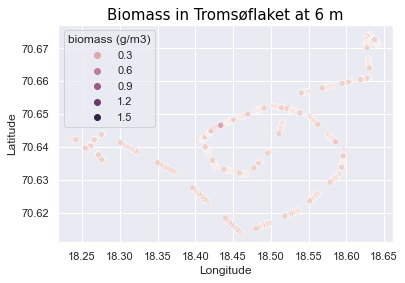

In [18]:
#Select depth bin * Must be even
select_depth = 6

#scatter plot
sns.scatterplot(data=NASC_df[NASC_df['depthbin_min']==select_depth], x='Longitude',y='Latitude',hue='biomass (g/m3)')
plt.title('Biomass in Tromsøflaket at %s m' %int(select_depth),title_font);

In [20]:
NASC_df.to_csv(r'.\Tromsoflaket_biomass.csv', index=None, sep=',', mode='a')